***
                                                                                                                데이터 출처: STATIZ   

# 주제: 2019 KBO 포스트시즌 진출팀의 2020년 평균 타율이 같은가? 

## 가설 세우기

__Ho: 2019 KBO 포스트시즌 진출팀들의 2020년 평균 타율은 같다.__
***
__Ha : not Ho__


## 패키지

In [79]:
import requests
from bs4 import BeautifulSoup
import re
import csv

import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 웹 스크래핑

In [81]:
# 웹 스크래핑 

teams = ["두산", "SK","키움","LG"]

for team in teams:

    with open("kbo_{}.csv".format(team), "w", encoding="utf-8-sig", newline="") as f:
        writer = csv.writer(f)
        title = "순 이름 팀 G 타석 타수 득점 안타 2타 3타 홈런 루타 타점 도루 도실 볼넷 사구 고4 삼진 병살 희타 희비 a 타율 c d e f g h j".split(' ')
        writer.writerow(title)

        for page in range(1, 3):
            print("현재 페이지는 {}페이지입니다.".format(page))
            headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"}
            url = "http://www.statiz.co.kr/stat.php?opt=0&sopt=0&re=0&ys=2020&ye=2020&se=0&te={0}&tm=&ty=0&qu=auto&po=0&as=&ae=&hi=&un=&pl=&da=1&o1=WAR_ALL_ADJ&o2=TPA&de=1&lr=0&tr=&cv=&ml=1&sn=30&si=&cn={1}".format(team, 30*(page-1))
            res = requests.get(url, headers = headers)
            soup = BeautifulSoup(res.content, "lxml")

            table = soup.find("table", attrs={"id":"mytable"})
            data_rows = table.find_all("tr")


            for row in data_rows:
                columns = row.find_all("td")
                if len(columns) <= 1 :
                    continue
                
                data = [col.get_text().strip() for col in columns]
                writer.writerow(data)
                
    print("-"*100)
    
print("작업이 완료되었습니다.")

현재 페이지는 1페이지입니다.
현재 페이지는 2페이지입니다.
----------------------------------------------------------------------------------------------------
현재 페이지는 1페이지입니다.
현재 페이지는 2페이지입니다.
----------------------------------------------------------------------------------------------------
현재 페이지는 1페이지입니다.
현재 페이지는 2페이지입니다.
----------------------------------------------------------------------------------------------------
현재 페이지는 1페이지입니다.
현재 페이지는 2페이지입니다.
----------------------------------------------------------------------------------------------------
작업이 완료되었습니다.


## 데이터 전처리

In [62]:
## select variables 

doosan = pd.read_csv("kbo_두산.csv", usecols= ["이름","팀","타석","타율"])
doosan["팀"] = "DOOSAN"

sk = pd.read_csv("kbo_SK.csv", usecols= ["이름","팀","타석","타율"])
sk["팀"] = "SK"

kium = pd.read_csv("kbo_키움.csv", usecols= ["이름","팀","타석","타율"])
kium["팀"] = "KIUM"

lg = pd.read_csv("kbo_LG.csv", usecols= ["이름","팀","타석","타율"])
lg["팀"] = "LG"


## merge data

team_list = [doosan, sk, kium, lg]
df = pd.concat(team_list)

## AB < 30 -> meaningless
df = df[lambda x:x.타석 >= 30]

# ANOVA test

__Ho: 2019년 포스트시즌 진출팀의 2020년 평균 타율은 같다.__
***
__Ha: not Ho__

## 팀별 타율 Boxplot

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54016 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 53440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54016 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 53440 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50984 missing from curre

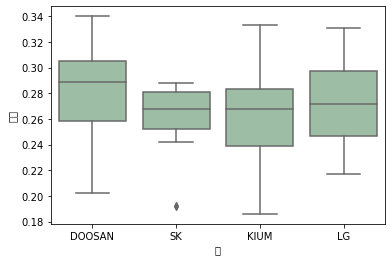

In [85]:
ax = sns.boxplot(x="팀", y="타율", data=df, color="#99c2a2")

### ANOVA table

In [86]:
model = ols("타율 ~ 팀", df).fit()
print(anova_lm(model))

             df    sum_sq   mean_sq         F    PR(>F)
팀           3.0  0.006087  0.002029  1.787653  0.153845
Residual  108.0  0.122573  0.001135       NaN       NaN


## ANOVA test assumption check 


### independency

__각 팀의 타자들이 치는 실력은 팀에 상관없이 독립이라고 가정한다.__   
__한 팀의 타자들은 서로 독립이라고 가정한다.__

### normality

ShapiroResult(statistic=0.9802508354187012, pvalue=0.09623414278030396)


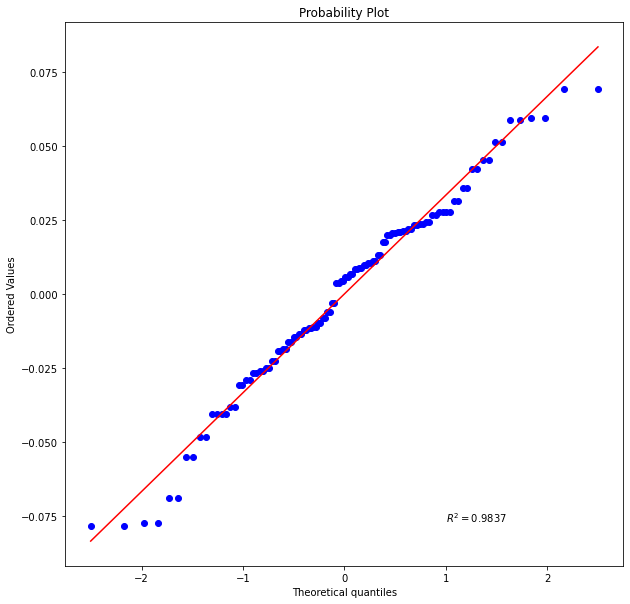

In [82]:
import scipy.stats as stats


print(stats.shapiro(model.resid))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot=plt, rvalue=True)
plt.show()

__정규성을 검정할 수 있는 Shapiro test의 p-value가 0.05보다 크므로 귀무가설(정규확률을 따른다.)를 그대로 채택한다.__   
__정규확률플롯에서 상당히 일치하는 모습을 보이므로 정규성을 만족한다.__

### equal variance

In [84]:
## Levene's test 

stats.levene(df[lambda x:x.팀 =="DOOSAN"]["타율"], 
            df[lambda x:x.팀 =="SK"]["타율"],
            df[lambda x:x.팀 =="KIUM"]["타율"],
            df[lambda x:x.팀 =="LG"]["타율"],
            center="median")

LeveneResult(statistic=2.332584156412959, pvalue=0.07815513133230603)

__등분산성을 검정할 수 있는 Levene test 결과 p-value가 0.05 이상이므로 귀무가설(등분산성을 만족한다.)을 그대로 채택한다.__

***
__ANOVA assumption 세 가지를 만족하므로 ANOVA test 시행이 성립 가능하다.__

__또한 ANOVA table의 p-value가 0.05보다 크므로 귀무가설(2019 KBO 포스트시즌 진출팀들의 2020년 평균 타율은 같다.)을 기각할 수 없다.__   
__따라서 2019 KBO 포스트시즌 진출팀들의 2020년 평균타율은 같다.__

***